# Brain Tumor Classification using a Fine-Tuned VGG16 Model

This notebook demonstrates how to build and train a deep learning model to classify brain tumors from MRI images. We will use a pre-trained VGG16 model and fine-tune it on the Brain Tumor Classification (MRI) dataset from Kaggle.

## 1. Set Up the Environment

In [1]:
!pip install tensorflow opencv-python matplotlib kaggle

## 2. Download the Dataset from Kaggle

To use the Kaggle API, you need to have a `kaggle.json` file in your `~/.kaggle/` directory. This file contains your Kaggle username and API key.

In [2]:
import os

os.environ['KAGGLE_USERNAME'] = ''  # Replace with your Kaggle username
os.environ['KAGGLE_KEY'] = ''  # Replace with your Kaggle API key

!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri
!unzip brain-tumor-classification-mri.zip

Dataset URL: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri
License(s): MIT
  0% 0.00/86.8M [00:00<?, ?B/s]
100% 86.8M/86.8M [00:00<00:00, 1.42GB/s]
Archive:  brain-tumor-classification-mri.zip
  inflating: Testing/glioma_tumor/image(1).jpg  
  inflating: Testing/glioma_tumor/image(10).jpg  
  inflating: Testing/glioma_tumor/image(100).jpg  
  inflating: Testing/glioma_tumor/image(11).jpg  
  inflating: Testing/glioma_tumor/image(12).jpg  
  inflating: Testing/glioma_tumor/image(13).jpg  
  inflating: Testing/glioma_tumor/image(14).jpg  
  inflating: Testing/glioma_tumor/image(15).jpg  
  inflating: Testing/glioma_tumor/image(16).jpg  
  inflating: Testing/glioma_tumor/image(17).jpg  
  inflating: Testing/glioma_tumor/image(18).jpg  
  inflating: Testing/glioma_tumor/image(19).jpg  
  inflating: Testing/glioma_tumor/image(2).jpg  
  inflating: Testing/glioma_tumor/image(20).jpg  
  inflating: Testing/glioma_tumor/image(21).jpg  
  inflating: Testing/glioma

## 3. Import Libraries

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt

## 4. Prepare the Data

In [4]:
# Define paths
train_dir = 'Training'
test_dir = 'Testing'

# Image parameters
img_height, img_width = 224, 224
batch_size = 32

# Data augmentation and preprocessing for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for testing
test_datagen = ImageDataGenerator(rescale=1./255)

# Load and prepare training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Load and prepare testing data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


## 5. Build and Train the Model

In [6]:
# Load the VGG16 model with pre-trained weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for classification
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

# Callbacks
checkpoint = ModelCheckpoint('brain_tumor_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, mode='min')

# Train the model
epochs = 20
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[checkpoint, reduce_lr]
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,562,308 (105.14 MB)

 Trainable params: 12,847,620 (49.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.4352 - loss: 1.3482

89/89 ━━━━━━━━━━━━━━━━━━━━ 56s 594ms/step - accuracy: 0.4364 - loss: 1.3454 - val_accuracy: 0.4271 - val_loss: 1.7502 - learning_rate: 1.0000e-04
Epoch 2/20
 1/89 ━━━━━━━━━━━━━━━━━━━━ 13s 159ms/step - accuracy: 0.7188 - loss: 0.7799

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7188 - loss: 0.7799 - val_accuracy: 0.4219 - val_loss: 1.7909 - learning_rate: 1.0000e-04
Epoch 3/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.6570 - loss: 0.8116

89/89 ━━━━━━━━━━━━━━━━━━━━ 83s 648ms/step - accuracy: 0.6572 - loss: 0.8112 - val_accuracy: 0.5104 - val_loss: 1.4903 - learning_rate: 1.0000e-04
Epoch 4/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.7188 - loss: 0.6494 - val_accuracy: 0.5078 - val_loss: 1.4637 - learning_rate: 1.0000e-04
Epoch 5/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.7250 - loss: 0.6832

89/89 ━━━━━━━━━━━━━━━━━━━━ 82s 705ms/step - accuracy: 0.7249 - loss: 0.6835 - val_accuracy: 0.5208 - val_loss: 1.4950 - learning_rate: 1.0000e-04
Epoch 6/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8750 - loss: 0.4815 - val_accuracy: 0.5130 - val_loss: 1.4776 - learning_rate: 1.0000e-04
Epoch 7/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 60s 477ms/step - accuracy: 0.7531 - loss: 0.6316 - val_accuracy: 0.4870 - val_loss: 1.5721 - learning_rate: 1.0000e-04
Epoch 8/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5938 - loss: 0.7433 - val_accuracy: 0.4922 - val_loss: 1.5426 - learning_rate: 1.0000e-04
Epoch 9/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.7596 - loss: 0.6033

89/89 ━━━━━━━━━━━━━━━━━━━━ 81s 490ms/step - accuracy: 0.7596 - loss: 0.6033 - val_accuracy: 0.5286 - val_loss: 1.5115 - learning_rate: 1.0000e-04
Epoch 10/20
 1/89 ━━━━━━━━━━━━━━━━━━━━ 14s 166ms/step - accuracy: 0.6875 - loss: 0.5943

89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.6875 - loss: 0.5943 - val_accuracy: 0.5312 - val_loss: 1.5079 - learning_rate: 2.0000e-05
Epoch 11/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.7933 - loss: 0.5405

89/89 ━━━━━━━━━━━━━━━━━━━━ 80s 525ms/step - accuracy: 0.7933 - loss: 0.5405 - val_accuracy: 0.5911 - val_loss: 1.5330 - learning_rate: 2.0000e-05
Epoch 12/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7188 - loss: 0.5252 - val_accuracy: 0.5911 - val_loss: 1.5375 - learning_rate: 2.0000e-05
Epoch 13/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.8024 - loss: 0.5382

89/89 ━━━━━━━━━━━━━━━━━━━━ 43s 478ms/step - accuracy: 0.8024 - loss: 0.5382 - val_accuracy: 0.6042 - val_loss: 1.5263 - learning_rate: 2.0000e-05
Epoch 14/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8750 - loss: 0.3967 - val_accuracy: 0.6016 - val_loss: 1.5305 - learning_rate: 2.0000e-05
Epoch 15/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 43s 477ms/step - accuracy: 0.8002 - loss: 0.5032 - val_accuracy: 0.6016 - val_loss: 1.5340 - learning_rate: 4.0000e-06
Epoch 16/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7812 - loss: 0.4292 - val_accuracy: 0.6016 - val_loss: 1.5344 - learning_rate: 4.0000e-06
Epoch 17/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 82s 925ms/step - accuracy: 0.8014 - loss: 0.5227 - val_accuracy: 0.5938 - val_loss: 1.5476 - learning_rate: 4.0000e-06
Epoch 18/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7500 - loss: 0.6552 - val_accuracy: 0.5938 - val_loss: 1.5499 - learning_rate: 4.0000e-06
Epoch 19/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 42s 477ms/step - accuracy: 0.80

## 6. Evaluate the Model

In [7]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 559ms/step - accuracy: 0.4101 - loss: 2.5633
Test accuracy: 0.6015


## 7. Plot Training Results

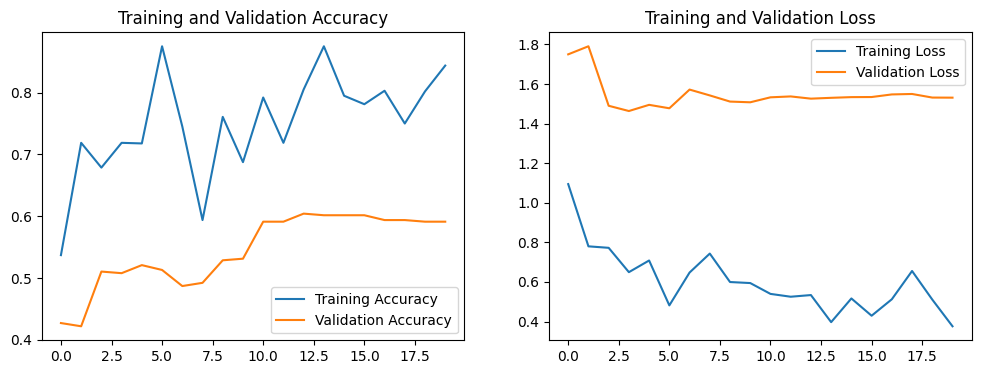

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## 8. Confusion Matrix

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step


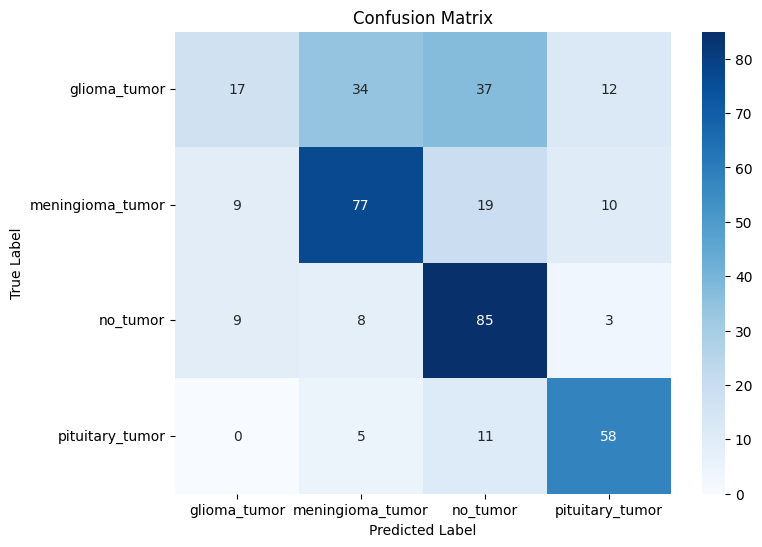

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions on the test set
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

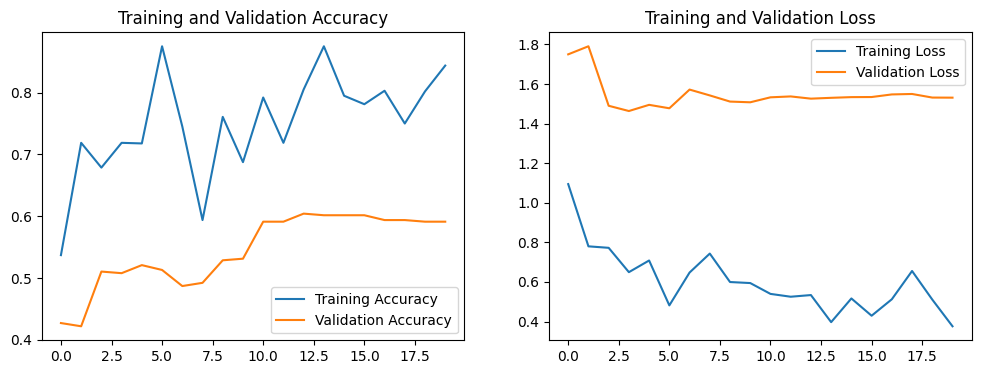

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()